In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

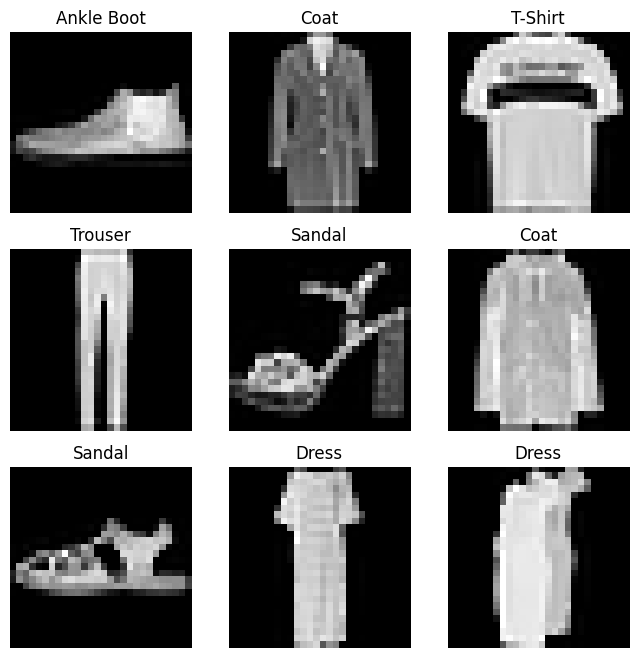

In [2]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [3]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True,drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True,drop_last=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


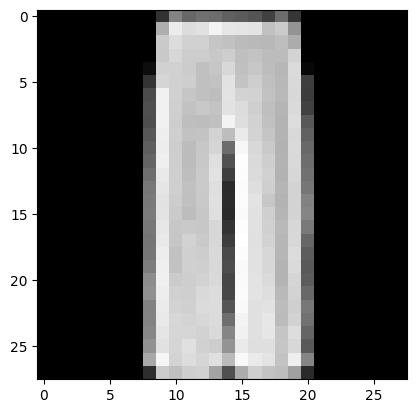

Label: 1


In [4]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [5]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [6]:
# import torch.nn as nn
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.flatten = nn.Flatten()
#         self.linear_relu_stack = nn.Sequential(
#             nn.Linear(28*28, 392),
#             nn.ReLU(),
#             nn.Linear(392, 10),
#         )

#     def forward(self, x):
#         x = self.flatten(x)
#         logits = self.linear_relu_stack(x)
#         return logits

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 392)
        self.fc2 = nn.Linear(392, 196)
        self.fc3 = nn.Linear(196, 10)
    def forward(self, x):
        img_input = torch.flatten(x, 1) # 1 is the starting dimension to flatten
        img_input = (img_input - torch.mean(img_input))/torch.std(img_input)
        img_input = torch.multiply(img_input,2)
        x = F.elu(self.fc1(img_input))
        x = F.elu(self.fc2(x))
        x = torch.multiply(x,2)
        logits = self.fc3(x)
        return logits
    

In [8]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=784, out_features=392, bias=True)
  (fc2): Linear(in_features=392, out_features=196, bias=True)
  (fc3): Linear(in_features=196, out_features=10, bias=True)
)


In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=3e-2)

In [10]:
def count_correct_predictions(pred,y):
    correct = 0
    total = 0
    
    for n, i in enumerate(pred):
        total += 1
        if torch.argmax(i) == y[n]:
            correct += 1
    
    print(f'Total predictions: {total}, Correct predictions: {correct}')

In [11]:
def train(dataloader, model, loss_fn, optimizer):

    size = len(dataloader.dataset)  # Size of the training dataset

    model.train()  # Set the model to training mode

    for b, (X, y) in enumerate(dataloader):  # Loop through each batch of data
        X, y = X.to(device), y.to(device)  # Move the inputs and targets to the GPU (if available)
        
        pred = model(X)  # Generate predictions for the current batch

        loss = loss_fn(pred, y)  # Compute the loss for the current batch

        loss.backward()  # Compute the gradients

        optimizer.step()  # Update the model's parameters
        optimizer.zero_grad()  # Zero the gradients
        
        # If we're at the 100th batch (or a multiple thereof), print the current loss and progress
        if b % 100 == 0:  
            loss, current = loss.item(), b * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    # At the end of each epoch, count the total and correct predictions and print them
    count_correct_predictions(pred,y)

In [12]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [13]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.377292  [    0/60000]
loss: 0.617269  [ 6400/60000]
loss: 0.359493  [12800/60000]
loss: 0.770220  [19200/60000]
loss: 0.601066  [25600/60000]
loss: 0.447664  [32000/60000]
loss: 0.607792  [38400/60000]
loss: 0.562046  [44800/60000]
loss: 0.326796  [51200/60000]
loss: 0.385283  [57600/60000]
Total predictions: 64, Correct predictions: 50
Test Error: 
 Accuracy: 84.6%, Avg loss: 0.422769 

Epoch 2
-------------------------------
loss: 0.419619  [    0/60000]
loss: 0.384221  [ 6400/60000]
loss: 0.317915  [12800/60000]
loss: 0.211193  [19200/60000]
loss: 0.387140  [25600/60000]
loss: 0.289945  [32000/60000]
loss: 0.325731  [38400/60000]
loss: 0.385247  [44800/60000]
loss: 0.383540  [51200/60000]
loss: 0.347843  [57600/60000]
Total predictions: 64, Correct predictions: 57
Test Error: 
 Accuracy: 85.8%, Avg loss: 0.389621 

Epoch 3
-------------------------------
loss: 0.252668  [    0/60000]
loss: 0.253960  [ 6400/60000]
loss: 0.381901  [12800

In [14]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [15]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [16]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
